<a href="https://colab.research.google.com/github/alexc6h6/Project_1_Plant_Seedling_Classification/blob/master/seedling_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Plant Seedlings Classification

Applying artificial intelligence increase of agricultural yields in an affordable way, in a short period, and with minimal human labor required. By using camera facilitate in the drone catches image for plant seedling and classifies by CNN to ckeck whether the plant seedling is the plant that would be growed or not.

The dataset are provided from Kaggle by The Aarhus University Signal Processing group. There are 12 species of plants at several growth stages. 

Each image contain plant and background with sand and rocks which might be the noise for Convolution neuron networks.

![alt text](https://storage.googleapis.com/kaggle-media/competitions/seedlings-classify/seedlings.png)

To generate the certain channel mask to cover the noice to increase accuracy in model training.

In [0]:
#!pip install --upgrade tensorflow

In [7]:
from google.colab import drive, files

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
import pandas as pd
import numpy as np
from keras.preprocessing import image
import os
from glob import glob
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Activation, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import regularizers
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

print(tf.__version__)

2.1.0


In [9]:
!ls '/content/drive/My Drive/plant-seedlings-classification'

sample_submission.csv  test  train


In [0]:
#load image dataset, tranfer image to array
train_folder_path = '/content/drive/My Drive/plant-seedlings-classification/train'

images = []
labels = []

for class_folder in os.listdir(train_folder_path):
  class_folder_path = os.path.join(train_folder_path, class_folder)
  for image_path in glob(os.path.join(class_folder_path, '*.png')):
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (128, 128))

    images.append(img)
    labels.append(class_folder)

images = np.array(images)
labels = np.array(labels)


In [12]:
print('image array shape')
print(images.shape)
print('label array shape')
print(labels.shape)


image array shape
(4750, 128, 128, 3)
label array shape
(4750,)


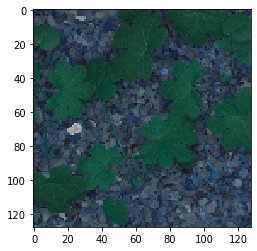

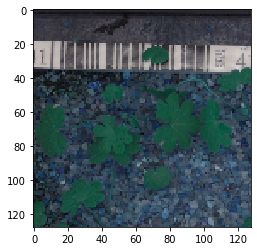

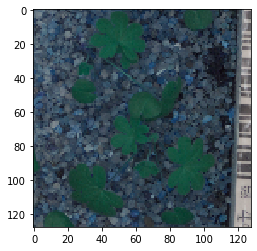

In [13]:
#print images
#there is some sand and rock on the background. It could be noicy when CNN extract the feature from image.
for image in images[:3]:
  plt.imshow(image)
  plt.show()


In [0]:
#create a mask to cover the background
masked_images = []

for image in images:
  blur = cv2.GaussianBlur(image, (5,5), 0) #blurred
  hsv = cv2.cvtColor(blur, cv2.COLOR_BGR2HSV)  #hsv converted
  lower = (25, 43, 46)
  upper = (77, 255, 255)
  mask = cv2.inRange(hsv, lower, upper)  #masked
  struc = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
  mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, struc)
  boolean = mask > 0  #boolean masked
  new = np.zeros_like(image, np.uint64) 
  new[boolean] = image[boolean]  #new modified image
  masked_images.append(new)

masked_images = np.asarray(masked_images)

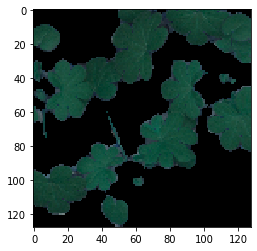

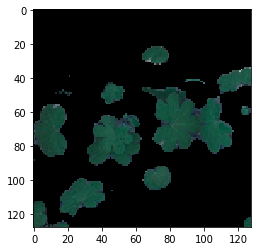

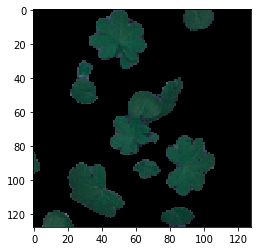

In [17]:
for image in masked_images[:3]:
  plt.imshow(image)
  plt.show()

In [20]:
#normalize image dataset
masked_images = masked_images/255

print(masked_images.shape)

(4750, 128, 128, 3)


In [21]:
#transform label into one_hot code label
le = LabelEncoder()
num_labels = le.fit_transform(labels)
ohe = OneHotEncoder(categories = 'auto')
ohe_labels = ohe.fit_transform(num_labels.reshape(-1, 1)).toarray()

print(ohe_labels.shape)

(4750, 12)


In [0]:
#split dataset into training set and validation set
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(masked_images, ohe_labels, test_size = 0.1)

In [0]:
#generate more data for training by using ImageDataGenerator

datagen = ImageDataGenerator(rotation_range = 180, width_shift_range = 0.1, height_shift_range = 0.1,
                             zoom_range = 0.1, shear_range = 0.1, horizontal_flip = True, vertical_flip = True)

datagen.fit(x_train)

In [37]:
model = tf.keras.models.Sequential([tf.keras.layers.Conv2D(64, (3,3), activation = 'relu', padding = 'same',
                                                           strides = 1, input_shape = (128, 128, 3)),
                                    tf.keras.layers.Conv2D(64, (3,3), activation = 'relu', padding = 'same',
                                                           strides = 1),
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.MaxPooling2D((2,2)),
                                    tf.keras.layers.Conv2D(128, (3,3), activation = 'relu', padding = 'same',
                                                           strides = 1),
                                    tf.keras.layers.Conv2D(128, (3,3), activation = 'relu', padding = 'same',
                                                           strides = 1),
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.MaxPooling2D((2,2)),
                                    tf.keras.layers.Conv2D(256, (3,3), activation = 'relu', padding = 'same',
                                                           strides = 1),
                                    tf.keras.layers.Conv2D(256, (3,3), activation = 'relu', padding = 'same',
                                                           strides = 1),
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.MaxPooling2D((2,2)),
                                    tf.keras.layers.Conv2D(512, (3,3), activation = 'relu', padding = 'same',
                                                           strides = 1),
                                    tf.keras.layers.Conv2D(512, (3,3), activation = 'relu', padding = 'same',
                                                           strides = 1),
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.MaxPooling2D((2,2)),
                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dropout(0.25),
                                    tf.keras.layers.Dense(512),
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.Activation('relu'),
                                    tf.keras.layers.Dropout(0.25),
                                    tf.keras.layers.Dense(12, activation = 'softmax')])

model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['acc'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_32 (Conv2D)           (None, 128, 128, 64)      1792      
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 128, 128, 64)      36928     
_________________________________________________________________
batch_normalization_19 (Batc (None, 128, 128, 64)      256       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 64, 64, 128)       73856     
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 64, 64, 128)       147584    
_________________________________________________________________
batch_normalization_20 (Batc (None, 64, 64, 128)      

In [0]:
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', patience = 8, min_lr = 0.00000001, verbose = 1)

In [39]:
batch = 64
epoch = 75

history = model.fit_generator(datagen.flow(x_train, y_train, batch_size = batch),
                              steps_per_epoch = len(x_train)/batch, 
                              epochs = epoch,
                              validation_data = (x_val, y_val),
                              verbose = 1,
                              callbacks = [reduce_lr])

  ...
    to  
  ['...']
Train for 66.796875 steps, validate on 475 samples
Epoch 1/75
67/66 [==============================] - 21s 319ms/step - loss: 1.4565 - acc: 0.5116 - val_loss: 4.9996 - val_acc: 0.1474
Epoch 2/75
67/66 [==============================] - 20s 299ms/step - loss: 0.9017 - acc: 0.6966 - val_loss: 7.5004 - val_acc: 0.0547
Epoch 3/75
67/66 [==============================] - 20s 300ms/step - loss: 0.7285 - acc: 0.7511 - val_loss: 15.8818 - val_acc: 0.0526
Epoch 4/75
67/66 [==============================] - 20s 300ms/step - loss: 0.6129 - acc: 0.7892 - val_loss: 19.2347 - val_acc: 0.0589
Epoch 5/75
67/66 [==============================] - 20s 300ms/step - loss: 0.5261 - acc: 0.8117 - val_loss: 20.0621 - val_acc: 0.0526
Epoch 6/75
67/66 [==============================] - 20s 299ms/step - loss: 0.4623 - acc: 0.8398 - val_loss: 16.2910 - val_acc: 0.0632
Epoch 7/75
67/66 [==============================] - 20s 301ms/step - loss: 0.4287 - acc: 0.8435 - val_loss: 11.0569 - val_

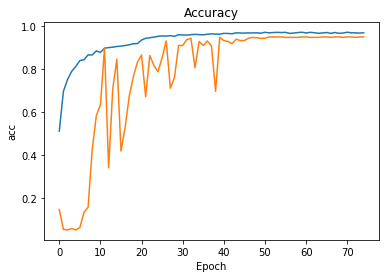

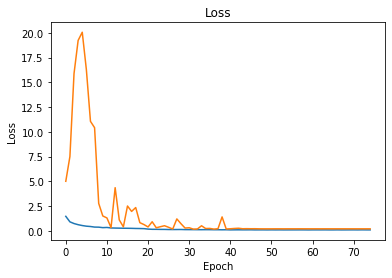

0.9494737
0.19521875362647206


In [40]:
#plot training accuracy and loss
def show_train_history_acc(history):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('acc')
    plt.show()

def show_train_history_loss(history):
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.title("Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

show_train_history_acc(history)
show_train_history_loss(history)

print(history.history['val_acc'][-1])
print(history.history['val_loss'][-1])

In [0]:
model.save('seedling_model.h5')